### Элементарные алгоритмы обработки временных рядов

Взять из прошлого домашнего задания ряд (в двух вариантах - стаицонарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображение почему была выбрана та или иная модель.

Загрузим необходимые библиотеки:

In [1]:
from scipy.stats import boxcox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline

Загрузим исходный ряд:

In [6]:
auto_registration = pd.read_csv("homework_monthly-us-auto-registration-tho.csv",sep=';')

Посмотрим, как выглядят наш нестанционарный ряд:

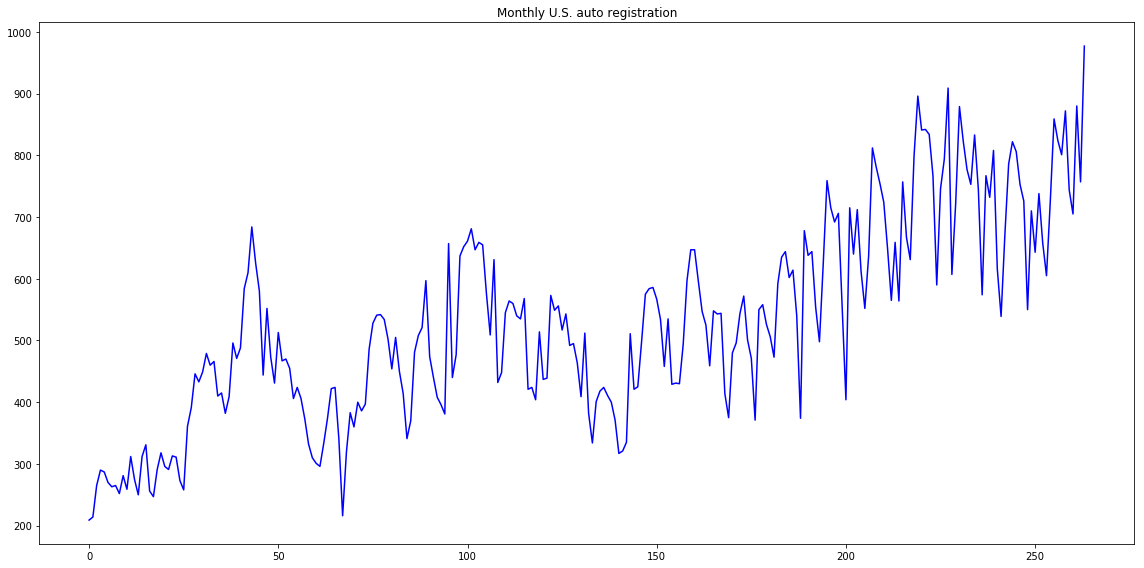

In [8]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
auto_registration["Count"].plot(ax=ts_ax, color='blue')
ts_ax.set_title("Monthly U.S. auto registration")
plt.tight_layout()

Разделим ряд на train и test, как 80% и 20% соответственно

In [9]:
int(auto_registration.shape[0]*0.8)

211

In [10]:
train = auto_registration[0:211]
test = auto_registration[210:]

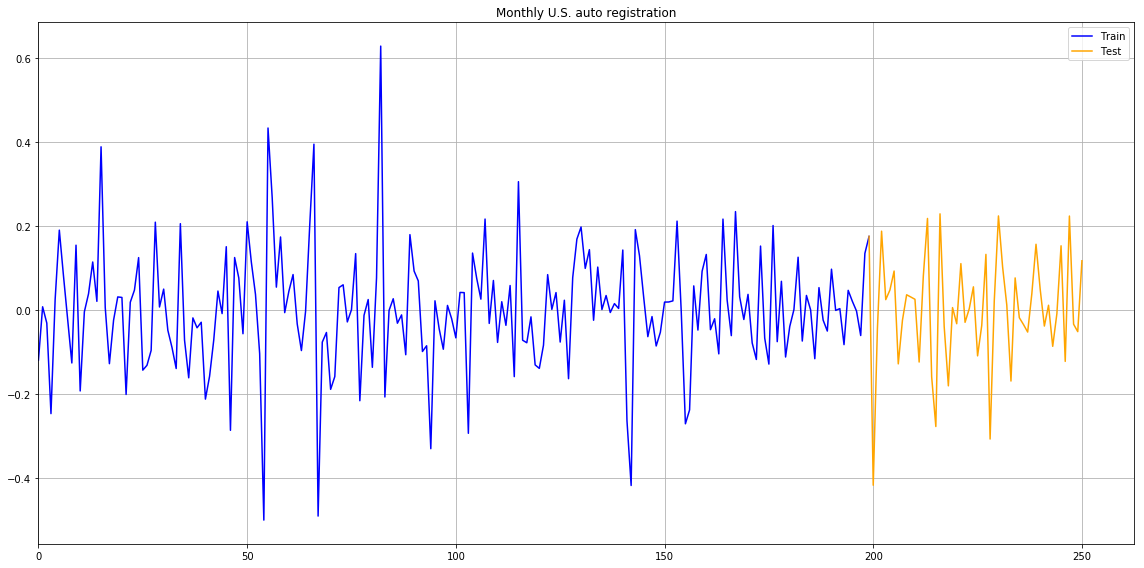

In [57]:
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
train.plot(ax=ts_ax, color='blue')
test.plot(ax=ts_ax, color='orange')
ts_ax.set_title("Monthly U.S. auto registration")
plt.legend(['Train',"Test"])
plt.grid(True)
plt.xlim(0)
plt.tight_layout()

Здесь есть тренд и сезонность, поэтому сразу применим Holt-Winter's метод, который учитывает компонент сезнности и тренда.

In [53]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [43]:
def initial_trend(series, season_len):
    sum=0.0
    for i in range(season_len):
        sum+=float(series[i+season_len]-series[i]) / season_len
    return sum / season_len

In [44]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [45]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [63]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    plt.figure(figsize=(14, 8))
    plt.plot(ser_to_plot, color='blue',label='original')
    plt.plot(tema, color='red', linewidth='2', label='TEMA')
    plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
    plt.grid(True)
    plt.legend()

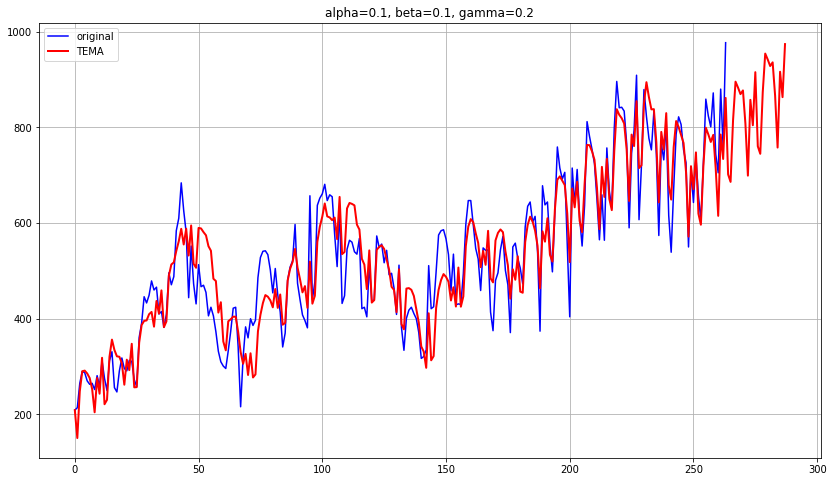

In [64]:
plot_tema(0.1, 0.1, 0.2,auto_registration['Count'] ,auto_registration['Count'] )

Подберем оптимальные коэффициенты alpha, beta, gamma

In [52]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [54]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [66]:
alpha, beta, gamma =opt.x 

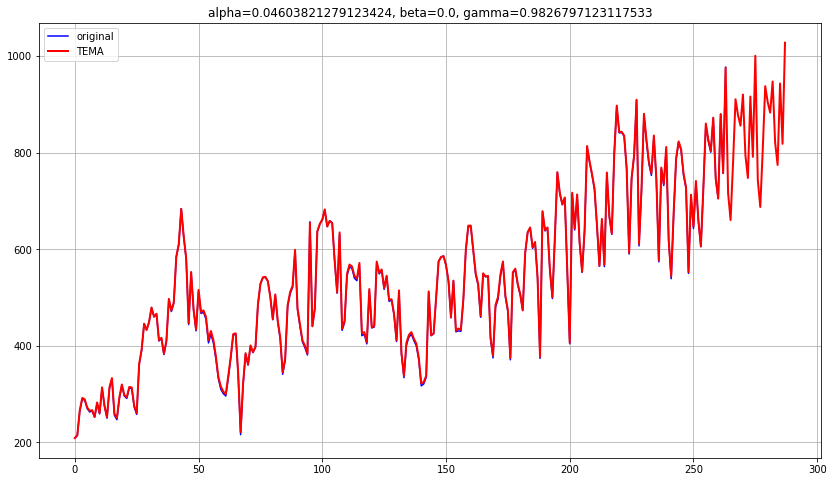

In [67]:
plot_tema(alpha, beta, gamma,auto_registration['Count'] ,auto_registration['Count'] )

Сделаем ряд стационарным

In [18]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [19]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Построим график автокорреляции и частичной автокорреляции:

In [20]:
series_auto_registration = auto_registration['Count'] 
series_auto_registration = boxcox(series_auto_registration, 0)
series_auto_registration = series_auto_registration[1:] - series_auto_registration[:-1]
series_auto_registration = series_auto_registration[12:] - series_auto_registration[:-12]

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


D:\Netology\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


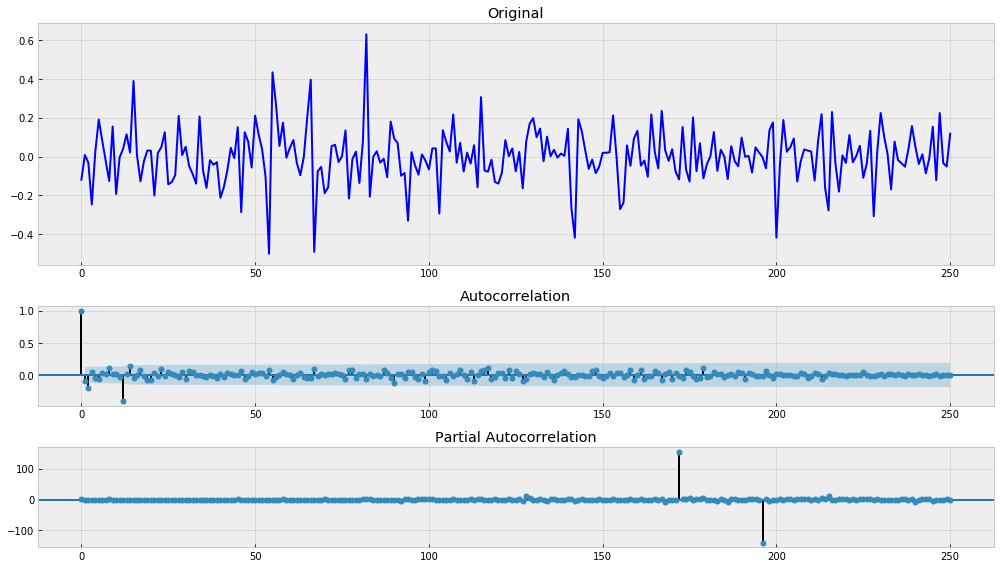

In [21]:
tsplot(series_auto_registration)

Разделим ряд на train и test, как 80% и 20% соответственно

In [31]:
series_auto_registration_m = pd.concat([pd.DataFrame(auto_registration["Month"]),pd.DataFrame(series_auto_registration)],axis=1)
series_auto_registration_m.columns=["Month","Count"]

In [35]:
series_auto_registration_m.head()

,Month,Count
0,1947-01,-0.118952
1,1947-02,0.007788
2,1947-03,-0.031036
3,1947-04,-0.246542
4,1947-05,0.025271


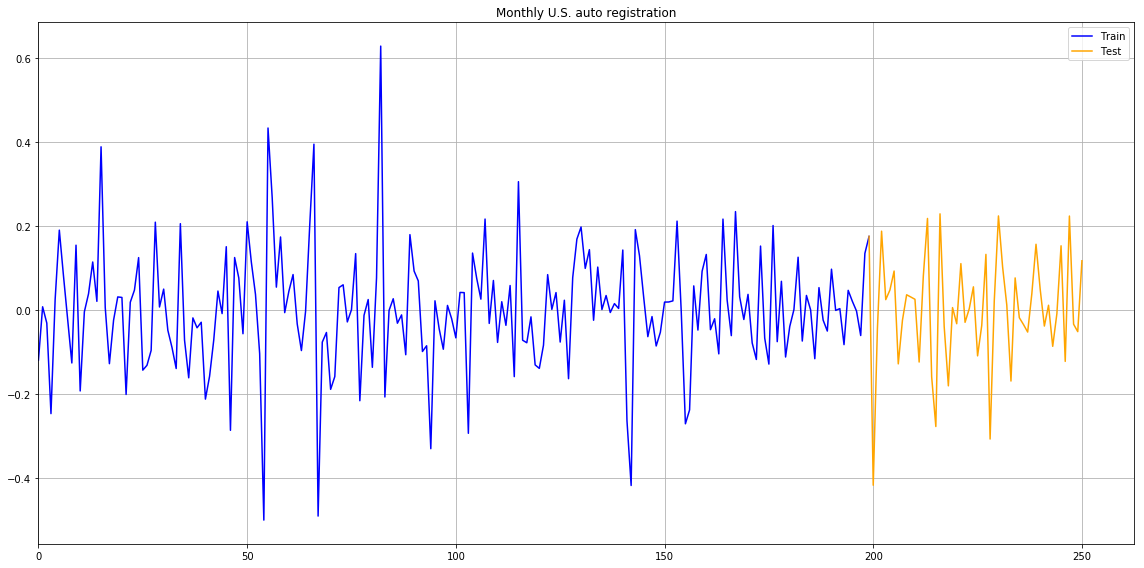

In [56]:
train = series_auto_registration_m[0:200]
test = series_auto_registration_m[199:]
plt.figure(figsize=(16, 8))
layout = (3, 2)
ts_ax = plt.subplot()
train.plot(ax=ts_ax, color='blue')
test.plot(ax=ts_ax, color='orange')
plt.legend(['Train',"Test"])
plt.xlim(0)
plt.grid(True)
ts_ax.set_title("Monthly U.S. auto registration")
plt.tight_layout()

In [7]:
def exponential_smoothing(series,alpha):
    result = [series[0]]
    for n in range(1,len(series)):
        result.append(alpha*series[n]+(1-alpha)*result[n-1])
    return result

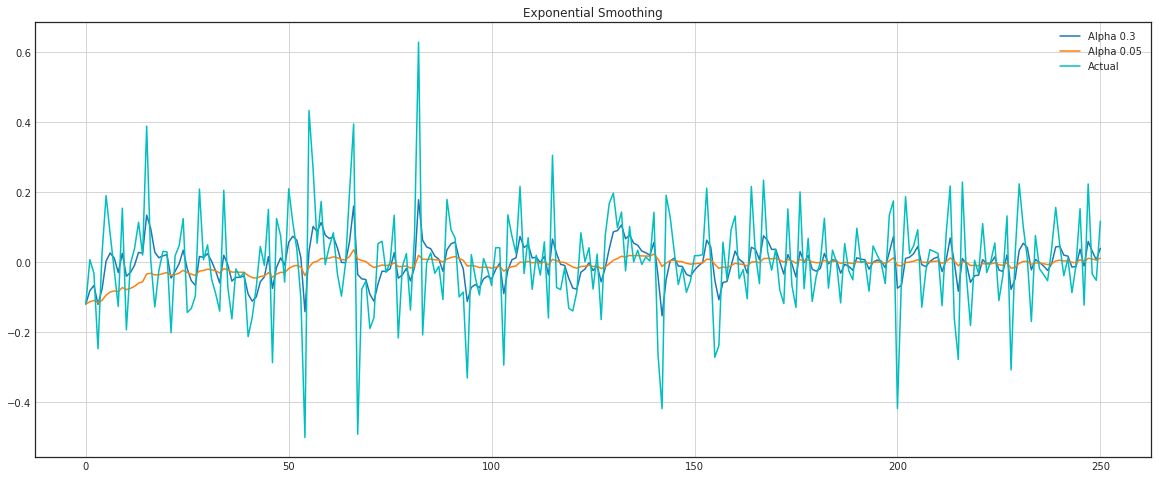

In [18]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20,8))
    for alpha in [0.3,0.05]:
        plt.plot(exponential_smoothing(series_auto_registration,alpha),label = "Alpha {}".format(alpha))
    plt.plot(series_auto_registration,"c",label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)

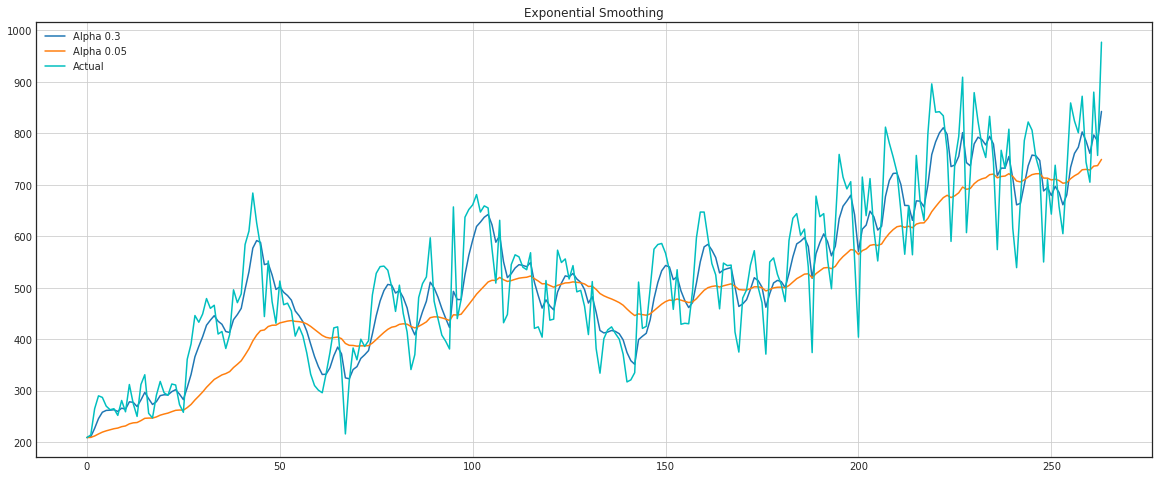

In [21]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20,8))
    for alpha in [0.3,0.05]:
        plt.plot(exponential_smoothing(auto_registration['Count'],alpha),label = "Alpha {}".format(alpha))
    plt.plot(auto_registration['Count'],"c",label="Actual")
    plt.legend(loc="best")
    plt.axis("tight")
    plt.title("Exponential Smoothing")
    plt.grid(True)